# Field components along track

In [1]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt 
from matplotlib import cm
from functools import partial
from multiprocessing import Pool
from scipy import stats
import numpy as np
import scipy.optimize
import gc #Garbage collector
import glob
from pybt.myjson.encoder import myJSONDecoder
import sys  
sys.path.insert(0, '/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction')
plt.style.use('default')
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
from functions import *
def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

/tmp/eljohnso/ipykernel_31840/2549597265.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Image


In [2]:
import importlib
import sys
importlib.reload(sys.modules['functions']) # Can be deleted - useful if modifications made to function file and not wanting to reload the whole notebook
from functions import *
from madx_functions import *

In [3]:
# settings for MADX
gamma = 25.598474067 # Previously obtained by: header_read, twiss_read = read_twiss_file('tfs/fast_extraction.twiss')
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
momentum = 24 # beam momentum (GeV/c)
Brho = momentum*3.3356

In [4]:
img = plt.imread("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/MU62_cropped_rotated_transparent.png")

In [5]:
MU_type= "U"
fieldmap = read_and_interpolate_fieldmap(MU_type,24)
interp_fieldmap = atr.interpolate_fieldmap(fieldmap)

reading field map U type: 4642A/MUU_4642_xy_grid.table


In [6]:
############################### Stray field calculation ###############################
# Calculate the trajectories
# input angle and position of the beam in the global reference system
particle = 'proton'       # particle name: 'proton' or 'carbon12'
PS_radius = 70.079
subtending_angle = (2*np.pi/100)
sagitta = PS_radius*(1-np.cos(subtending_angle/2))
chord = PS_radius*2*np.sin(subtending_angle/2)

extraction_offset = 0.132 # Roughly 13 cm
extraction_angle = 0.0139626 # 0.8 deg
x_offset = + extraction_offset*np.cos(subtending_angle/2)
z_offset = + extraction_offset*np.sin(subtending_angle/2)

track_end_z_m = chord/2 # approximate location in longitudinal direction of the magnet at where to stop the tracking 

ang_glob = (subtending_angle/2 + extraction_angle, 0.0)
pos_glob = (-sagitta+x_offset,  0.0, -(chord/2+z_offset))

# Create particles
setGen = atr.SetGenerator(particle)
distr_part_ref = {'dX': 0, 'dXP': 0, 'dY': 0, 'dYP': 0, 'dS': 0, 'en_MeV': momentum_to_energy(momentum)*1000, 'dt': 0} # Distribution of the reference particle in local coordinate system | kinetic energy of the beam in MeV
set13_local = setGen.get_part13_local(distr_part_ref, dX=1e-3, dXP=1e-3, dY=1e-3, dYP=1e-3, dt=4e-12, dD=1e-3) # set of distributions for 13 particles in local coordinate system
set13_global = setGen.get_partset_global(set_local=set13_local, pos_glob0=pos_glob, ang_glob0=ang_glob) # set of distributions for 13 particles in global coordinate system to be used for tracking

# run reference particle to determine the tracking-end line for the entire set
plane_ref = trackend_plane(interp_fieldmap, particle, set13_global[0], track_end_z_m)
def track_is_inside(x ,p , t, a=plane_ref[0], b=plane_ref[1], c=plane_ref[2], d=plane_ref[3]):
    return x[2] < -(a * x[0] + b * x[1] + d  ) / c

# Deletes the file content if it wasn't empty
f = open("/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt", "w")
f.write(f"") 
f.close()

# run only particle 0
input_zip = [set13_global[0]+(track_is_inside,)]
with Pool(6) as p:
    partial_track_one_particle = partial(track_one_particle, interp_fieldmap, particle) # We provide a subset of variables\n",
    tracks_set = p.map(partial_track_one_particle, input_zip)
tracks1 = atr.Tracks(tracks_set, particle)

track_z = tracks1.tracks_set[0]["z"]
track_x = tracks1.tracks_set[0]["x"]
track_y = tracks1.tracks_set[0]["y"]

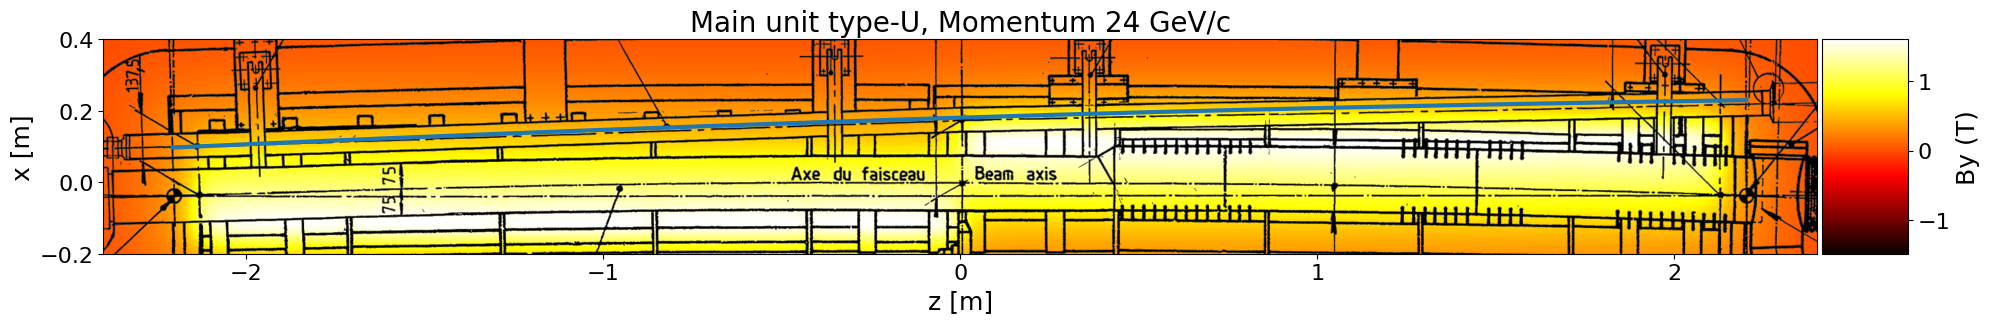

In [7]:
############################### Plotting ###############################
fig, ax = plt.subplots(figsize=(20, 8), tight_layout = True)
ax.plot(tracks1.tracks_set[0]["z"],tracks1.tracks_set[0]["x"], lw=3, label = f"Particle tracking")
plot_fieldmap_faster(fig, ax, fieldmap, "By", 'y',"z","x",0.0)
plot_background(fig, ax, img, (717,890), (4129,891))
ax.set_title(f"Main unit type-{MU_type}, Momentum {momentum} GeV/c")
ax.set_xlim(-2.4,2.4)
ax.set_ylim(-0.2,0.4)
plt.savefig("fig/mfc_mu62_track.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

In [8]:
fig, ax = plt.subplots(figsize=(20, 8), tight_layout = True)
ax.plot(tracks1.tracks_set[0]["z"],tracks1.tracks_set[0]["y"], lw=3, label = f"Particle tracking")
plot_fieldmap_faster(fig, ax, fieldmap, "By", 'x',"z","y",0.0)
ax.set_title(f"Main unit type-{MU_type}, Momentum {momentum} GeV/c")
ax.set_xlim(-2.4,2.4)
ax.set_ylim(-0.2,0.4)

(-0.2, 0.4)

# B-field along the track

In [40]:
import pandas as pd
import numpy as np

# Assuming track_z, track_x, and track_y are numpy arrays

# Calculate distances between each point and the next
distances = np.sqrt(np.diff(track_x)**2 + np.diff(track_z)**2)

# Initialize track_s array
track_s = np.zeros_like(track_x)

# Calculate cumulative distance for each point
track_s[1:] = np.cumsum(distances)

# Building the DataFrame
track = pd.DataFrame({
    'x': track_x,
    'y': track_y,
    'z': track_z,
    's': track_s
})


## First order terms

In [37]:
By_list = []
Bx_list = []
Bz_list = []

for i in range(len(track_z)):
    By =  interp_fieldmap["By"]([track_x[i],
                                track_y[i],
                                track_z[i]])[0]
    By_list.append(By)
    Bx =  interp_fieldmap["Bx"]([track_x[i],
                                track_y[i],
                                track_z[i]])[0]
    Bx_list.append(Bx)
    Bz =  interp_fieldmap["Bz"]([track_x[i],
                                track_y[i],
                                track_z[i]])[0]
    Bz_list.append(Bz)


fig,ax = plt.subplots()
ax.plot(track.s, By_list, label="By")
ax.plot(track.s, Bx_list, label="Bx")
ax.plot(track.s, Bz_list, label="Bz")
ax.set_xlabel("s [m]")
ax.set_ylabel("B [T]")
ax.legend()

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming track_x, track_y, and track_z are defined and interp_fieldmap is defined
# Also assuming that they are all numpy arrays of the same length

By_values = np.zeros_like(track_x)  # Initialize an array to store the By values

# Calculate the By values at each point
for i in range(len(track_z)):
    By_values[i] = interp_fieldmap["By"]([track_x[i],
                                          track_y[i],
                                          track_z[i]])[0]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# The color of each point is determined by the By value
sc = ax.scatter(track_x, track_y, track_z, c=By_values)

# Add a colorbar to the figure
fig.colorbar(sc, ax=ax, label='By')

# Set the labels of the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


# Second order terms
We probe the field transversly

In [108]:
# We probe the field transversly

fig, ax = plt.subplots(2,2, tight_layout=True, figsize=(12,8))


subset=1
colors = plt.cm.jet(np.linspace(0,1,int(len(track_x)/subset)))

# List that computes the s distance along the track
track_s = []
track_s.append(0)
old_hypothenus = 0
for i in range(int(len(track_x)/subset)-1):
    z = (track_z[i+1]-track_z[i])**2
    x = (track_x[i+1]-track_x[i])**2
    hypothenus = np.sqrt(z + x)
    s = hypothenus+old_hypothenus
    track_s.append(s)
    old_hypothenus = s
tracks_s = np.array(track_s)

for B_i in ["Bx", "By"]:
    for x_j in ["x", "y"]:

        zeroth_order_da = []
        first_order_da = []
        second_order_da = []
        third_order_da = []

        for i in range(int(len(track_x)/subset)):

            offset_list = []
            B_list = []

            center_x = track_x[int(i*subset)]
            probing_range = 0.035 # in meters
            transverse_range = np.linspace(-probing_range,probing_range,100)

            
            # We find the correct B-field value at the offset location
            for offset in (transverse_range):

                if x_j == "x":

                    if i>0:
                        deflection_angle=-np.arctan( (track_x[i*subset]-track_x[i*subset-1*subset])/(track_z[i*subset]-track_z[i*subset-1*subset]) ) #rad
                    else:
                        deflection_angle = -ang_glob[0]

                    B =  interp_fieldmap[B_i]([center_x + offset*np.cos(deflection_angle),
                                                0,
                                                track_z[int(i*subset)]+offset*np.sin(deflection_angle)])[0]
                    
                    offset = offset*np.cos(deflection_angle)
                    offset_list.append(offset)
                    B_list.append(B)

                if x_j == "y":

                    B =  interp_fieldmap[B_i]([center_x,
                                                offset,
                                                track_z[int(i*subset)]])[0]
                    offset_list.append(offset)
                    B_list.append(B)
                
            # Polynomial fit
            offset_list = np.array(offset_list)
            poly_fit = np.polyfit(offset_list, B_list, 3)

            # print (f"Multipole field component with deflection: {round(poly_fit[-1],3), round(poly_fit[-2],3), round(poly_fit[-3],3), round(poly_fit[-4],3)}")

            zeroth_order_da.append(poly_fit[-1]/Brho)
            first_order_da.append(poly_fit[-2]/Brho)
            second_order_da.append(poly_fit[-3]/Brho)
            third_order_da.append(poly_fit[-4]/Brho)

        zeroth_order_da = np.array(zeroth_order_da)
        first_order_da = np.array(first_order_da)
        second_order_da = np.array(second_order_da)
        third_order_da = np.array(third_order_da)
                
        ax[0,0].plot(np.array(track_s), zeroth_order_da, label=B_i)
        ax[0,1].plot(np.array(track_s), first_order_da, label=f"d{B_i}/d{x_j}")
        ax[1,0].plot(np.array(track_s), second_order_da, label=f"$\frac{{d^2{B_i}}}{{d{x_j}^2}}$")
        ax[1,1].plot(np.array(track_s), third_order_da, label=f"$\frac{{d^3{B_i}}}{{d{x_j}^3}}$")

        ax[0,0].set_title("Dipole component")
        ax[0,0].set_xlabel("s [m]")
        ax[0,1].set_title("Quadrupole component")
        ax[0,0].set_xlabel("s [m]")
        ax[1,0].set_title("Sextupole component")
        ax[0,0].set_xlabel("s [m]")
        ax[1,1].set_title("Octupole component")
        ax[0,0].set_xlabel("s [m]")

ax[0,0].legend(loc="upper right")
ax[0,1].legend(loc="upper right")
ax[1,0].legend(loc="upper right")
ax[1,1].legend(loc="upper right")

Error in callback <function _draw_all_if_interactive at 0x7f81eb2725e0> (for post_execute):


ValueError: 
$rac{d^2Bx}{dx^2}$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$rac{d^2Bx}{dx^2}$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1200x800 with 4 Axes>

In [72]:
zeroth_order_da = np.array(zeroth_order_da)
first_order_da = np.array(first_order_da)
second_order_da = np.array(second_order_da)
third_order_da = np.array(third_order_da)

In [74]:
fig, ax = plt.subplots(2,2, tight_layout=True)
ax[0,0].plot(np.array(track_s), zeroth_order_da, label="MFC model")

ax[0,1].plot(np.array(track_s), first_order_da, label="MFC model")

ax[1,0].plot(np.array(track_s), second_order_da, label="MFC model")

ax[1,1].plot(np.array(track_s), third_order_da, label="MFC model")

ax[0,0].set_title("Dipole component")
ax[0,0].set_xlabel("s [m]")

ax[0,1].set_title("Quadrupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,0].set_title("Sextupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,1].set_title("Octupole component")
ax[0,0].set_xlabel("s [m]")

Text(0.5, 0, 's [m]')

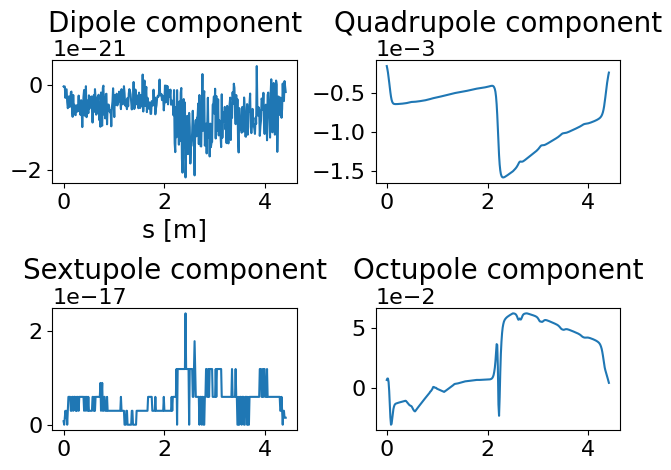

In [75]:
# Normalised with the length for export to MAD-X
zeroth_order_dan = zeroth_order_da*(track_s[-1]/len(track_s))
first_order_dan = first_order_da*(track_s[-1]/len(track_s))
second_order_dan = second_order_da*(track_s[-1]/len(track_s))
third_order_dan = third_order_da*(track_s[-1]/len(track_s))

fig, ax = plt.subplots(2,2, tight_layout=True)
ax[0,0].plot(np.array(track_s), zeroth_order_dan, label="MFC model")

ax[0,1].plot(np.array(track_s), first_order_dan, label="MFC model")

ax[1,0].plot(np.array(track_s), second_order_dan, label="MFC model")

ax[1,1].plot(np.array(track_s), third_order_dan, label="MFC model")

ax[0,0].set_title("Dipole component")
ax[0,0].set_xlabel("s [m]")

ax[0,1].set_title("Quadrupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,0].set_title("Sextupole component")
ax[0,0].set_xlabel("s [m]")

ax[1,1].set_title("Octupole component")
ax[0,0].set_xlabel("s [m]")

In [70]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tracks1.tracks_set[0]["z"], tracks1.tracks_set[0]["x"], color="b")

plot_fieldmap_faster(fig, ax, fieldmap, "By", 'y',"z","x",0.0)

colors = plt.cm.jet(np.linspace(0,1,int(len(track_x)/subset)))
for i in range(int(len(track_z)/subset)):
    
    center_x = track_x[i*subset]
    
    if i>0:
        deflection_angle=-np.arctan( (track_x[i*subset]-track_x[i*subset-1*subset])/(track_z[i*subset]-track_z[i*subset-1*subset]) ) #rad
    else:
        deflection_angle = -ang_glob[0]
    
    x_probing_list = []
    z_probing_list = []
    
    for offset in (transverse_range):
        # By =  interp_fieldmap["By"]([center_x + offset*np.cos(deflection_angle) ,0,track_z[i*subset]+offset*np.sin(deflection_angle)])[0]
        x_probing_list.append(center_x + offset*np.cos(deflection_angle))
        z_probing_list.append(track_z[i*subset]+offset*np.sin(deflection_angle))
        # By_list.append(By)
    ax.plot(z_probing_list,x_probing_list, color=colors[i], lw=5)

ax.set_aspect("equal")
plot_background(fig, ax, img, (717,890), (4129,891))
ax.set_xlim(-2.4,2.4)
ax.set_ylim(-0.2,0.4)

(-0.2, 0.4)